In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from matplotlib.animation import FuncAnimation, PillowWriter

In [40]:
# Constants
# Constants
L = 1.0  # Length of the box (arbitrary units)
N = 1000  # Number of spatial slices
a = L / N  # Spatial step size
h = 1e-9  # Time step (nano seconds)
M = 1.0  # Particle mass (arbitrary units)
hbar = 1.0  # Reduced Planck's constant (arbitrary units)

# # Discretization coefficients
# b = 1 - 1j * h * hbar / (2 * M * a**2)
# b2 = 1j * h * hbar / (4 * M * a**2)
scaling_factor = 1e6  # Amplify for testing
b = 1 - 1j * scaling_factor * h * hbar / (2 * M * a**2)
b2 = 1j * scaling_factor * h * hbar / (4 * M * a**2)

# Spatial grid
x = np.linspace(0, L, N+1)

# Initial wavefunction (Gaussian wave packet)
sigma = 0.1  # Width of the wave packet
x0 = L / 2  # Initial position of the wave packet
psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * 5 * np.pi * x / L)
psi[0] = psi[-1] = 0  # Boundary conditions (psi = 0 at walls)

# Matrix A and B setup
main_diag_A = np.full(N-1, b)
off_diag_A = np.full(N-2, b2)
main_diag_B = np.full(N-1, np.conj(b))
off_diag_B = np.full(N-2, np.conj(b2))

In [41]:
def crank_nicolson_step(psi):
    # Compute vector v = B * psi
    v = np.zeros(N-1, dtype=complex)
    for i in range(1, N-2):
        v[i] = (
            main_diag_B[i] * psi[i+1]
            + off_diag_B[i-1] * psi[i]
            + off_diag_B[i] * psi[i+2]
        )
    v[0] = main_diag_B[0] * psi[1] + off_diag_B[0] * psi[2]
    v[-1] = main_diag_B[-1] * psi[-2] + off_diag_B[-1] * psi[-3]

    # Solve Ax = v for x (psi at next time step)
    ab = np.zeros((3, N-1), dtype=complex)
    ab[0, 1:] = off_diag_A  # Upper diagonal
    ab[1, :] = main_diag_A  # Main diagonal
    ab[2, :-1] = off_diag_A  # Lower diagonal
    psi_next = solve_banded((1, 1), ab, v)

    # Enforce boundary conditions directly on psi_next
    psi_next_full = np.zeros_like(psi, dtype=complex)  # Full array including boundaries
    psi_next_full[1:-1] = psi_next  # Assign the interior points
    psi_next_full[0] = 0  # Enforce boundary condition at x=0
    psi_next_full[-1] = 0  # Enforce boundary condition at x=L
    
    # print("Main diagonal of A:", main_diag_A[:5])
    # print("Off diagonal of A:", off_diag_A[:5])
    # print("Vector v:", v[:5])
    
    # print(f"Real Part of Psi (Before Update): {np.real(psi[:5])}")
    # print(f"Imaginary Part of Psi (Before Update): {np.imag(psi[:5])}")

    # print(f"Real Part of Psi (Updated Interior): {np.real(psi_next[:5])}")
    # print(f"Imaginary Part of Psi (Updated Interior): {np.imag(psi_next[:5])}")

    # print(f"Real Part of Psi (With Boundary): {np.real(psi_next_full[:5])}")
    # print(f"Imaginary Part of Psi (With Boundary): {np.imag(psi_next_full[:5])}")


    return psi_next_full


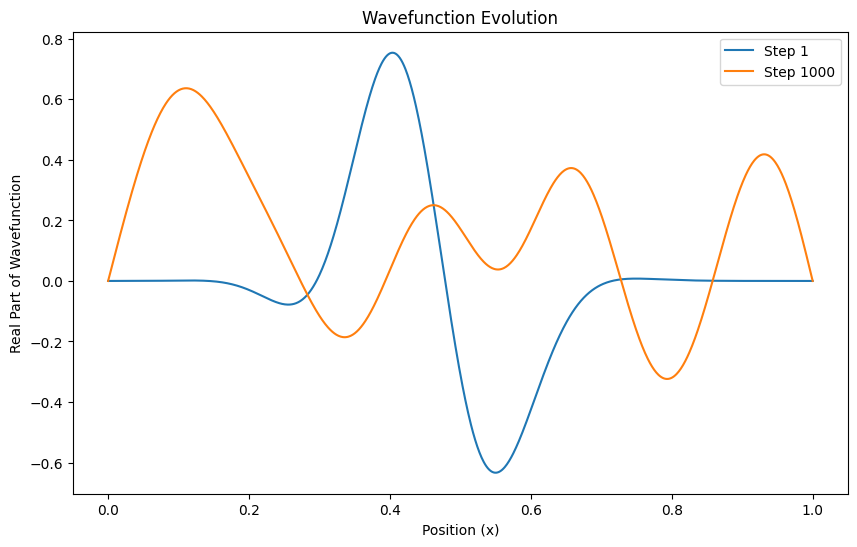

In [47]:
num_steps = 1000
psi_t = psi.copy()

plt.figure(figsize=(10, 6))
plt.plot(x, np.real(psi_t), label=f"Step {1}")
for step in range(1, num_steps + 1):
    psi_t = crank_nicolson_step(psi_t)
    if step % 1000 == 0:  # Plot every 2 steps
        plt.plot(x, np.real(psi_t), label=f"Step {step}")

plt.xlabel("Position (x)")
plt.ylabel("Real Part of Wavefunction")
plt.title("Wavefunction Evolution")
plt.legend()
plt.show()

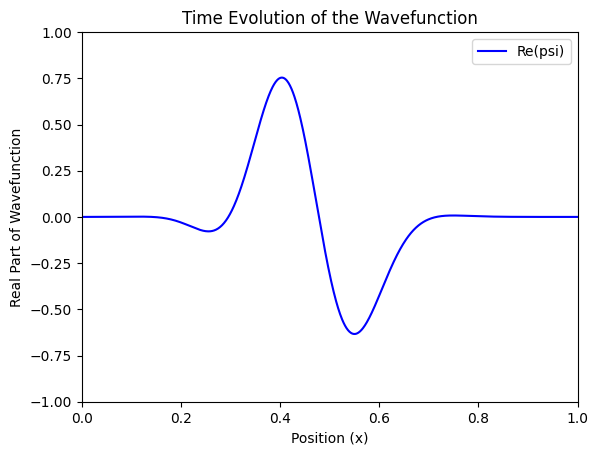

In [43]:
# Animation setup
fig, ax = plt.subplots()
line, = ax.plot(x, np.real(psi), label="Re(psi)", color="blue")
ax.set_xlim(0, L)
ax.set_ylim(-1, 1)  # Adjust limits based on expected amplitude
ax.set_xlabel("Position (x)")
ax.set_ylabel("Real Part of Wavefunction")
ax.set_title("Time Evolution of the Wavefunction")
ax.legend()

# Animation update function
def update(frame):
    global psi
    psi = crank_nicolson_step(psi)
    line.set_ydata(np.real(psi))  # Update line with real part of psi
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=100, interval=50, blit=True)

plt.show()